In [1]:
import sys
sys.version_info

sys.version_info(major=3, minor=9, micro=13, releaselevel='final', serial=0)

In [2]:
import torch
import torch.nn as nn
from torch.cuda.amp import autocast
from easydict import EasyDict as edict
import yaml
import pandas as pd
import os, argparse, sys
# from ISIC2020_Dataset import ISIC2020TorchDataset, NORM_CHANNEL_MEAN, NORM_CHANNEL_STD
from torch.utils.data import DataLoader
import numpy as np
import torchvision.transforms as T
from time import perf_counter
from sklearn.metrics import confusion_matrix, roc_auc_score
from torchsummary import summary

# from DarwinNet_659MF import DarwinNetV2, IntDarwinNetV2, ResHead

In [3]:
import os
from torchvision.datasets.folder import pil_loader
from torch.utils.data import Dataset

NORM_CHANNEL_MEAN = [0.806, 0.621, 0.592]
NORM_CHANNEL_STD = [0.151, 0.177, 0.203]

class ISIC2020TorchDataset(Dataset):
    def __init__(self, data_files, isic_image_dir, targets=None, transform=None):
        self.isic_image_dir = isic_image_dir
        self.data = data_files
        self.targets = targets
        self.transform = transform

    def __len__(self):
        print(len(self.data))
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image_path = os.path.join(self.isic_image_dir, self.data[idx])
        image = pil_loader(image_path)
        if self.transform is not None:
            image = self.transform(image)
            
        if self.targets is not None:
            target = self.targets[idx]
            return image, target
        else: 
            return image, self.data[idx]

In [4]:
"""

Module for building ResNet Module according to different config file
"""
from torch.nn import Module
import torch.nn as nn
import warnings
from collections import OrderedDict


def conv2d(w_in, w_out, k, *, stride=1, groups=1, dilation=1, bias=False):
    """Helper for building a conv2d layer."""
    assert k % 2 == 1, "Only odd size kernels supported to avoid padding issues."
    s, p, g, b = stride, (k - 1) // 2, groups, bias
    return nn.Conv2d(w_in, w_out, k, stride=s, padding=p, groups=g, bias=b)


def norm2d(w_in):
    """Helper for building a norm2d layer."""
    return nn.BatchNorm2d(num_features=w_in, eps=1e-5, momentum=0.1)


def pool2d(_w_in, k, *, stride=1):
    """Helper for building a pool2d layer."""
    assert k % 2 == 1, "Only odd size kernels supported to avoid padding issues."
    return nn.MaxPool2d(k, stride=stride, padding=(k - 1) // 2)


def pool2d_average(_w_in, k, *, stride=1):
    """Helper for building a pool2d layer."""
    assert k % 2 == 1, "Only odd size kernels supported to avoid padding issues."
    return nn.AvgPool2d(k, stride=stride, padding=(k - 1) // 2)


def gap2d(_w_in):
    """Helper for building a gap2d layer."""
    return nn.AdaptiveAvgPool2d((1, 1))


def linear(w_in, w_out, *, bias=False):
    """Helper for building a linear layer."""
    return nn.Linear(w_in, w_out, bias=bias)


def activation():
    """Helper for building an activation layer."""
    return torch.nn.SiLU()


def get_transformation_function(func_name):
    "Returns the transformation function for ResNet Module"
    functions_available = {"basic": BasicTransform, "bottleneck": BottleneckTransform}
    try:
        func = functions_available[func_name]
        return func
    except:
        raise (ValueError("Function not available"))


class BasicTransform(Module):
    """Basic transformation: 3x3, BN, AF, 3x3, BN."""

    expansion: int = 1

    def __init__(
        self,
        inplanes,
        channels,
        stride=1,
        downsample=None,
        groups=1,
        base_width=64,
        dilation=1,
        attn=False,
    ):
        super(BasicTransform, self).__init__()
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")

        self.stride = stride
        self.inplanes = inplanes
        self.channels = channels

        if stride != 1:
            self.avgpool = nn.AvgPool2d(2, stride=stride)
            self.conv1 = conv2d(self.inplanes, self.channels, 3, groups=4)
        else:
            self.conv1 = conv2d(
                self.inplanes, self.channels, 3, stride=self.stride, groups=4
            )

        # self.conv1 = conv2d(self.inplanes, self.channels, 3, stride=self.stride)
        self.bn1 = norm2d(self.channels)
        self.relu = activation()
        self.conv2 = conv2d(self.channels, self.channels, 3, groups=4)
        self.bn2 = norm2d(self.channels)
        self.downsample = downsample
        self.attn = attn
        # self.softmax = nn.Softmax()

    def forward(self, x):
        identity = x

        if self.stride != 1:
            out = self.avgpool(x)
            out = self.conv1(out)
        else:
            out = self.conv1(x)
        # out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.attn:
            # print("Using Attn in Basic Block")
            if self.downsample is not None:
                identity = self.downsample(x)
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    out = torch.nn.functional.softmax(out)
                out = torch.mul(out, identity)
            else:
                out += identity
        else:
            if self.downsample is not None:
                identity = self.downsample(x)
            out += identity

        out = self.relu(out)

        return out


class BottleneckTransform(Module):
    """Bottleneck transformation: 1x1, BN, AF, 3x3, BN, AF, 1x1, BN."""

    expansion: int = 2

    def __init__(
        self,
        inplanes,
        channels,
        stride=1,
        downsample=None,
        groups=1,
        base_width=64,
        dilation=1,
        attn=False,
    ):
        super(BottleneckTransform, self).__init__()
        width = int(channels * (base_width / 64.0)) * groups
        self.stride = stride
        self.conv1 = conv2d(inplanes, width, 1, groups=1)
        self.bn1 = norm2d(width)

        if stride != 1:
            self.avgpool = nn.AvgPool2d(2, stride=stride)
            self.conv2 = conv2d(width, width, 3, stride=1, groups=4, dilation=dilation)
        else:
            self.conv2 = conv2d(
                width, width, 3, stride=stride, groups=4, dilation=dilation
            )

        # self.conv2 = conv2d(width, width, 3, stride=stride, groups=groups, dilation=dilation)
        self.bn2 = norm2d(width)
        self.conv3 = conv2d(width, channels * self.expansion, 1, groups=1)
        self.bn3 = norm2d(channels * self.expansion)
        self.relu = activation()
        self.downsample = downsample
        self.stride = stride
        self.width = width
        self.inplanes = inplanes
        self.channels = channels
        self.groups = groups
        self.dilation = dilation
        self.downsample = downsample
        self.attn = attn

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        if self.stride != 1:
            out = self.avgpool(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.attn:
            if self.downsample is not None:
                identity = self.downsample(x)
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    out = torch.nn.functional.softmax(out)
                out = torch.mul(out, identity)
            else:
                out += identity
        else:
            if self.downsample is not None:
                identity = self.downsample(x)
            out += identity

        out = self.relu(out)

        return out


class ResHead(Module):
    """ResNet head: AvgPool, 1x1."""

    def __init__(self, w_in, num_classes):
        super(ResHead, self).__init__()
        self.w_in = w_in
        self.num_classes = num_classes
        self.avg_pool = gap2d(w_in)
        self.fc = linear(w_in, num_classes, bias=True)

    def forward(self, x):
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        return x
        # x = self.fc(x)
        # return x


class DarwinStemIN(Module):
    """ResNet stem for ImageNet: 7x7, BN, AF, MaxPool."""

    def __init__(self, w_in, w_out):
        super(DarwinStemIN, self).__init__()
        self.w_in = w_in
        self.w_out = w_out

        self.relu = activation()

        self.conv1 = conv2d(w_in, w_out, 3, stride=2)
        self.bn1 = norm2d(w_out)
        self.conv2 = conv2d(w_out, w_out, 3, stride=1, groups=4)
        self.bn2 = norm2d(w_out)

        self.pool = pool2d_average(w_out, 3, stride=2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.pool(x)

        return x


class DarwinNetV2(Module):
    """DarwinNetV2 model."""

    def __init__(self, blockspecs, input_shape, num_classes, in_chans = 3, model_structure=[[None]]):
        super(DarwinNetV2, self).__init__()
        self.blockspecs = blockspecs
        
        self.channels = [max(4, b[0] - b[0] % 4) for b in self.blockspecs]
        self.model_depth = [b[1] for b in self.blockspecs]
        self.attn = [b[6] for b in self.blockspecs]
        
        
        self.replace_stride_with_dilation = [False for i in range(len(self.channels))]
        self.module_types = ["basic", "basic", "bottleneck", "bottleneck"]

        self.num_channels = len(self.channels)
        self.blocks = []
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.dilation = 1
        self.base_width = 64
        self.groups = 1
        assert self.num_channels == len(self.model_depth)
        self._construct_imagenet()

    def _construct_imagenet(self):
        depth = self.model_depth
        self.inplanes = 32
        self.stem = DarwinStemIN(self.input_shape[2], self.inplanes)

        for i in range(len(self.channels)):
            if i == 0:
                self.blocks.append(
                    self._make_layer(
                        get_transformation_function(self.module_types[i]),
                        self.channels[i],
                        stride=1,
                        depth=depth[i],
                        attn=self.attn[i],
                    )
                )
            else:
                self.blocks.append(
                    self._make_layer(
                        get_transformation_function(self.module_types[i]),
                        self.channels[i],
                        stride=2,
                        depth=depth[i],
                        dilate=self.replace_stride_with_dilation[i - 1],
                        attn=self.attn[i],
                    )
                )
        self.blocks = nn.ModuleList(self.blocks)
        self.head = ResHead(
            self.channels[self.num_channels - 1]
            * get_transformation_function(
                self.module_types[self.num_channels - 1]
            ).expansion,
            self.num_classes,
        )
        # model = nn.Sequential(*[self.stem, self.blocks, self.head])
        # return model

    def _make_layer(self, module_type, channels, stride, depth, dilate=False, attn=False):
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1

        if stride != 1:
            downsample = nn.Sequential(
                nn.AvgPool2d(2, stride=stride),
                conv2d(
                    self.inplanes,
                    channels * module_type.expansion,
                    1,
                    stride=1,
                    groups=1,
                ),
                norm2d(channels * module_type.expansion),
            )
        elif self.inplanes != channels * module_type.expansion:
            downsample = nn.Sequential(
                conv2d(
                    self.inplanes,
                    channels * module_type.expansion,
                    1,
                    stride=stride,
                    groups=1,
                ),
                norm2d(channels * module_type.expansion),
            )

        layers = []
        layers.append(
            module_type(
                self.inplanes,
                channels,
                stride,
                downsample,
                self.groups,
                self.base_width,
                previous_dilation,
                attn=attn,
            )
        )
        self.inplanes = channels * module_type.expansion
        for _ in range(1, depth):
            layers.append(
                module_type(
                    self.inplanes,
                    channels,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    attn=attn,
                )
            )

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.stem(x)
        for i in range(self.num_channels):
            x = self.blocks[i](x)
        x = self.head(x)
        return x
    
class IntDarwinNetV2(DarwinNetV2):
    def __init__(self, output_layer, *args):
        self.output_layer = output_layer
        super().__init__(*args)

        self._layers = []
        for l in list(self._modules.keys()):
            self._layers.append(l)
            if l == output_layer:
                break
        self.layers = OrderedDict(zip(self._layers,[getattr(self,l) for l in self._layers]))

    def _forward_impl(self, x):
        for l in self._layers:
            x = self.layers[l](x)

        return x

    def forward(self, x):
        return self._forward_impl(x)


In [5]:
def args_parser():
    parser = argparse.ArgumentParser(description='CancerNet-SCa x AttendNeXt Inferece')
    parser.add_argument('--weightspath', default='final-model.pth', type=str, help='Path to trained model weights')
    parser.add_argument('-mc', '--model-config', default='DarwinNet_XA_325MF.yml', help='Path to model config file')
    parser.add_argument('-dd', '--data-dir', type=str, default='train/', help='Sample image directory')
    parser.add_argument('-ttf', '--test-split-file', type=str, default='test_input.csv', help='CSV file with one test input')
    parser.add_argument('-tf', '--split-file', type=str, default='ISIC_2020_Training_GroundTruth.csv', help='CSV file with actual results for image directory')
    parser.add_argument('-tsf', '--test-file', type=str, default='ISIC_2020_Test_Metadata.csv', help='CSV file with test results for image directory')
    parser.add_argument('-sz', '--size', type=int, default=224, help='Square image size')
    parser.add_argument('-mp', '--mixed-precision', action='store_true', help='Flag to enable mixed-precision')
    parser.add_argument('-df', '--data-file-name', type=str, default='sample_data_predictions.csv', help='Name of csv file for predictions')
    parser.add_argument('-gi', '--gpu-id', type=int, default=0, help='GPU device ID')
    parser.add_argument("-f", required=False)

    args, unknown = parser.parse_known_args()
    return args

args = args_parser()
# start_time = perf_counter()

print("Starting script")

num_classes = 1

HYPERPARAMETERS = yaml.load(open(args.model_config, "r"), Loader=yaml.FullLoader)
config = edict(HYPERPARAMETERS)
device = 'cuda:{}'.format(args.gpu_id) if args.gpu_id >= 0 else 'cpu'
# device = torch.cuda.device('cuda')
model = DarwinNetV2(config.model_cfg, config.input_shape, num_classes)
state_dict = torch.load(args.weightspath, map_location=device)
model.load_state_dict(state_dict)
model = model.to(device)
print(device)


test_tform = T.Compose([
    T.Resize((args.size, args.size)),
    T.ToTensor(),
    T.Normalize(NORM_CHANNEL_MEAN, NORM_CHANNEL_STD)
])


Starting script
cuda:0


In [6]:
# Read and load data
data_df = pd.read_csv(args.split_file)
data_files = data_df['isic_id'].to_numpy()
actual_vals = data_df['target'].to_numpy()
actual_diag = data_df['diagnosis'].to_numpy()
isic_dataset = ISIC2020TorchDataset(
    data_files, args.data_dir, transform=test_tform
)
test_loader = DataLoader(isic_dataset, batch_size=256, shuffle=False, num_workers=0)

In [25]:
# Test how long it takes to get the embeddings of a single input image.

start_time = perf_counter()

# all_predictions = []
test_image_names = []
test_embeddings = []
model.eval()
with torch.no_grad():
    for data, image_names in test_loader:
        data = data.to(device)
        with autocast(enabled=args.mixed_precision):
            embeddings = model((data))
            
            print(embeddings.detach().cpu().numpy().shape)
            logits = torch.squeeze(model(data))
            predictions = torch.sigmoid(logits)
            # save embeddings here
        # test_embeddings.append(embeddings.detach().cpu().numpy())
        test_embeddings.extend(embeddings.detach().cpu().numpy())
        for image_name in image_names:
            test_image_names.append(image_name)

end_time = perf_counter()
actual_vals = np.array(actual_vals)
diagnosis = np.array(actual_diag)
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time}")

print(test_image_names)

1
(1, 744)
Elapsed time: 0.2356208000001061
['ISIC_0015719.jpg']


In [ ]:
# RUN ONLY IF NECESSARY - gets embeddings and image names (Consider moving image names separately or keeping original)

# all_image_names = [] # Comment out precaution
# all_embeddings = [] # COP
model.eval()
start_time = perf_counter()
with torch.no_grad():
    for data, image_names in test_loader:
        data = data.to(device)
        with autocast(enabled=args.mixed_precision):
            embeddings = model((data))
            
            print(embeddings.detach().cpu().numpy().shape)
            # save embeddings here
        # all_embeddings.append(embeddings.detach().cpu().numpy())
        all_embeddings.extend(embeddings.detach().cpu().numpy())
        for image_name in image_names:
            all_image_names.append(image_name)
        print(f"current all_embeddings vector shape: {np.array(all_embeddings).shape}")

In [ ]:
# RUN ONLY IF NECESSARY - Writes pickle file of image names
import csv
import pickle

# my_data = {'image_names': all_image_names} # COP
output = open('image_names.pkl', 'wb')
pickle.dump(my_data, output)
output.close()

# np.savez('embeddings.npz', all_embeddings)


In [7]:
# RUN ONLY IF NECESSARY - Reads pickle file of embeddings

import csv
import pickle

pkl_file = open('embeddings1.pkl', 'rb')

stored_embeddings = pickle.load(pkl_file)['embeddings'] # COP

print(np.array(stored_embeddings).shape)

pkl_file.close()

(33126, 744)


In [8]:
# RUN ONLY IF NECESSARY - Reads pickle file of image names

pkl_file = open('image_names.pkl', 'rb')

stored_image_names = pickle.load(pkl_file)['image_names'] # COP

print(np.array(stored_image_names).shape)

pkl_file.close()

(33126,)


In [9]:
# split data into testing and training
from sklearn.model_selection import train_test_split
train_ratio = 0.70
validation_ratio = 0.29
test_ratio = 0.01

X = stored_embeddings
X = pd.DataFrame(X)
y = actual_vals
y = pd.Series(y)
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=1-train_ratio, random_state=1,  stratify=y)

X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=1, stratify=Y_test)

print(len(X_test))
print(np.array(X_train).shape)
print(X_test.index)
print(Y_test.index)

332
(23188, 744)
Index([24417, 11199, 18822,  5801, 19242, 25821, 11965, 25452,  7927,  4769,
       ...
       25371, 17016,  7016, 12736, 32701, 11540, 30581, 22289, 10897,  6985],
      dtype='int64', length=332)
Index([24417, 11199, 18822,  5801, 19242, 25821, 11965, 25452,  7927,  4769,
       ...
       25371, 17016,  7016, 12736, 32701, 11540, 30581, 22289, 10897,  6985],
      dtype='int64', length=332)


In [ ]:
# split data into testing and validation and training set using indices
from sklearn.model_selection import StratifiedShuffleSplit
X = stored_embeddings
y = actual_vals

sss = StratifiedShuffleSplit(n_splits=5, test_size=1-train_ratio, random_state=0)
for train_ind, test_ind in sss.split(X, y):


In [10]:
from PIL import Image
import matplotlib.pyplot as plt
import math

def most_common(lst):
    return max(set(lst), key=lst.count)

def plot_similar_images(indices_list, input_ind):
    correct_vals = 0
    false_pos = 0
    false_neg = 0
    mal_1 = 0
    input_name = stored_image_names[input_ind]
    img_path = os.path.join(args.data_dir + input_name)
    # print("Input:")
    # print(img_path)
    acc = actual_vals[input_ind]
    # print(f"Benign/Malignant: {actual_vals[input_ind]}")
    # print(f"Diagnosis: {actual_diag[input_ind]}")
    # img = Image.open(img_path).convert("RGB")
    # plt.imshow(img)
    # plt.show()
    # print("Results")
    diagnoses = []
    for index in indices_list:
        img_name = stored_image_names[index]
        img_path = os.path.join(args.data_dir + img_name)
        prediction = actual_vals[index]
        diagnoses.append(prediction)
        # print(img_path)
        # print(f"Benign/Malignant: {actual_vals[index]}")
        # print(f"Diagnosis: {actual_diag[index]}")
       
        # img = Image.open(img_path).convert("RGB")
        # plt.imshow(img)
        # plt.show()
        
    common_diag = most_common(diagnoses)  
    # print(f"Prediction: {common_diag}")
    if common_diag == acc:
        correct_vals += 1
    elif acc == 0:
        false_pos = 1
        print("FALSE POSITIVE")
    elif acc == 1:
        if 1 in diagnoses:
            mal_1 = 1
        false_neg = 1
        print("FALSE NEGATIVE")
    # print(correct_vals)
    return common_diag, correct_vals, false_pos, false_neg, mal_1

In [ ]:
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.cluster import KMeans

import random

def find_nearest_k(k, input_ind, all_embdngs, training_embdngs):
    k += 1
    knn = NearestNeighbors(n_neighbors=k, metric="euclidean")
    tr_embdgs = np.asarray(training_embdngs)
    # print(tr_embdgs.shape)

    # print(all_embdngs[input_ind].reshape((1, -1)).shape)

    # input_embdng = all_embdngs[input_ind]
    # print(input_embdng)
    # embeddings = np.delete(all_embeddings, (input_ind), axis=0)
    # print(embeddings.shape)

    knn.fit(training_embdngs)
    # print(all_embdngs[input_ind].reshape((1, -1)).shape)
    
    dists, indices = knn.kneighbors(all_embdngs[input_ind].reshape((1, -1)))
    indices_list = indices.tolist()[0]
    indices_list = indices_list[1:]

    
    print(f"Input index: {input_ind}, indices retrieved: {indices_list}")
    return indices_list, training_embdngs, dists


# start_time = perf_counter()
# indices_list, _= find_nearest_k(5, 2, all_embeddings)
# end_time = perf_counter()

# elapsed_time = end_time - start_time
# print(elapsed_time * 1000)

num_embeddings = np.array(X_train).shape[0]
print(f'Number of training data: {num_embeddings}')
corr = 0
f_poss = 0
f_negs = 0
mal_1s = 0
predictions = []

for i in X_val.index:
    indices_list, _, dists= find_nearest_k(5, i, stored_embeddings, X_train)
    prediction, correct, f_pos, f_neg, mal_1 = plot_similar_images(indices_list, i)
    predictions.append(prediction)
    corr += correct
    f_poss += f_pos
    f_negs += f_neg
    mal_1s += mal_1
print(corr)
print(f_poss)
print(f_negs)
print(mal_1s)

start classifier = K-Neighbours
confusion_matrix: 
 [[9426   11]
 [ 165    4]]


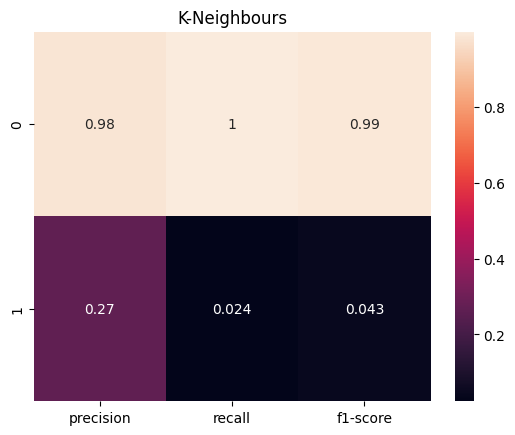

Time elapsed for crossval: 104.34998859999996s
start classifier = Gradient Boosting


KeyboardInterrupt: 

In [18]:
from collections import Counter
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
import seaborn as sns

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
models = [KNeighborsClassifier(n_neighbors=5), GradientBoostingClassifier(random_state=0), RandomForestClassifier(random_state=0)]
names = ["K-Neighbours", "Gradient Boosting", "Random Forest"]
k_values = [5, 7, 9, 11]
cv_scores = []
acc = []
auc = []

for model, name in zip(models, names):
    start_time = perf_counter()
    print(f"start classifier = {name}")
    model = model.fit(X_train, Y_train)
    pred = model.predict(X_val)
    
    cv_results = cross_val_score(model, X, y, cv=cv, scoring="roc_auc")

    cv_scores.append(cv_results)
    acc.append(cross_val_score(model, X, y, scoring="accuracy", cv=cv, n_jobs=-1).mean()) # Storing accuracy values
    auc.append(cross_val_score(model, X, y, scoring="roc_auc", cv=cv, n_jobs=-1).mean()) # Storing AUC-ROC scores


    print("confusion_matrix: \n", metrics.confusion_matrix(Y_val, pred))

    clf_report = metrics.classification_report(Y_val, pred, output_dict=True)
    plt.figure()
    plt.title(name)
    sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :-3].T, annot=True)
    plt.show()

    end_time = perf_counter()
    elapsed_time = end_time - start_time
    print(f"Time elapsed for crossval: {elapsed_time}s")


# Accuracy and AUC-ROC Scores
scores = pd.DataFrame(list(zip(names, acc, auc)), columns =["Algorithm", "Accuracy Score", "AUC-ROC Score"]) 
print(scores)

# Plotting AUC-ROC
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(cv_scores)
plt.xlabel('Algorithm')
plt.ylabel('AUC-ROC')
ax.set_xticklabels(names)
plt.xticks(rotation=45)
plt.show()

print(Counter(Y_train))
print(Counter(Y_val))

In [17]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()

X_smote, y_smote = oversample.fit_resample(X, y)

Counter(y_smote)

Counter({0: 32542, 1: 32542})

In [25]:
# start_time = perf_counter()
# indices_list, _, dists= find_nearest_k(7, 1, stored_embeddings)
# end_time = perf_counter()

# elapsed_time = end_time - start_time
# print(f"Elapsed time: {elapsed_time}")

num_embeddings = np.array(X_train).shape[0]
print(f'Number of training data: {num_embeddings}')
corr = 0
f_poss = 0
f_negs = 0
mal_1s = 0

for i in X_val.index:
    print(i)
    indices_list, _, dists= find_nearest_k(7, i, stored_embeddings, X_train)
    correct, f_pos, f_neg, mal_1 = plot_similar_images(indices_list, i)
    corr += correct
    f_poss += f_pos
    f_negs += f_neg
    mal_1s += mal_1
print(corr)

Number of training data: 23188
15356
(23188, 744)
0        1.020788e-05
1        6.790751e-05
2        1.708969e-05
3        1.081220e-04
4        3.238122e-05
             ...     
33121    1.907046e-04
33122    2.438706e-05
33123    3.887878e-07
33124    7.380883e-06
33125    2.533965e-01
Name: 5, Length: 33126, dtype: float32


KeyError: 15356

In [74]:
print(f"false positives: {f_poss}")
print(f"false negatives: {f_negs}")
print(f"mal_1: {mal_1s}")

false positives: 5
false negatives: 20
mal_1: 10


In [11]:
# PCA projection
import plotly.express as px
from sklearn.decomposition import PCA

pca = PCA(n_components=2).fit_transform(X_test)

fig = px.scatter(x=pca[:, 0], y=pca[:, 1], color=y_test)
fig.update_layout(
    title="PCA visualization of Custom Classification dataset",
    xaxis_title="First Principal Component",
    yaxis_title="Second Principal Component",
)
fig.show()

In [12]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=270, random_state=42)

X_tsne = tsne.fit_transform(np.array(X_test))
print(tsne.kl_divergence_)

fig = px.scatter(x=X_tsne[:, 0], y=X_tsne[:, 1], color=y_test, opacity=0.9)
fig.update_layout(
    title="t-SNE visualization of Custom Classification dataset",
    xaxis_title="First t-SNE",
    yaxis_title="Second t-SNE",
)
fig.show()

0.3644973933696747


In [37]:
# determine appropriate perplexity

perplexity = np.arange(50, 300, 5)
divergence = []

for i in perplexity:
    model = TSNE(n_components=2, init="pca", perplexity=i)
    reduced = model.fit_transform(np.array(X_test))
    divergence.append(model.kl_divergence_)
fig = px.line(x=perplexity, y=divergence, markers=True)
fig.update_layout(xaxis_title="Perplexity Values", yaxis_title="Divergence")
fig.update_traces(line_color="red", line_width=1)
fig.show()

In [ ]:
# K-means testing
kmeans = KMeans(init='k-means++', n_clusters=5, n_init=4)
kmeans.fit(pca)

output = kmeans.predict(pca)
x = embeddings

plt.figure(figsize=(6,6))
plt.scatter(x[output==0,0], x[output==0,1], label='category 0')
plt.scatter(x[output==1,0], x[output==1,1], label='category 1')
plt.scatter(x[output==2,0], x[output==2,1], label='category 2')
plt.scatter(x[output==3,0], x[output==3,1], label='category 3')
plt.scatter(x[output==4,0], x[output==4,1], label='category 4')
plt.legend()
plt.title("k-means clustering $k=5$")
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()